In [513]:
import pandas as pd
import numpy as np
import math
import pickle

from scipy import stats
import scipy.io
from scipy.spatial.distance import pdist
from scipy.linalg import cholesky
from scipy.io import loadmat

import matlab.engine as engi
import matlab as mat

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,roc_auc_score,recall_score,precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from pyearth import Earth
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer

from src import SMOTE
from src import CFS
from src import metrices_V2 as metrices

import platform
from os import listdir
from os.path import isfile, join
from glob import glob
from pathlib import Path
import sys
import os
import copy
import traceback
from pathlib import Path

# Venn diag
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

# Individual images

precision process 0.94
precision product 0.48
precision process+product 0.93
recall process 0.98
recall product 0.43
recall process+product 0.99
pf process 0.04
pf product 0.3
pf process+product 0.04
f1 process 0.94
f1 product 0.44
f1 process+product 0.94
g process 0.97
g product 0.45
g process+product 0.97
auc process 0.9545454545454545
auc product 0.5488844772168652
auc process+product 0.9540472851132038
pci_20 process 0.67
pci_20 product 0.71
pci_20 process+product 0.67
ifa process 0.0
ifa product 50.0
ifa process+product 0.0


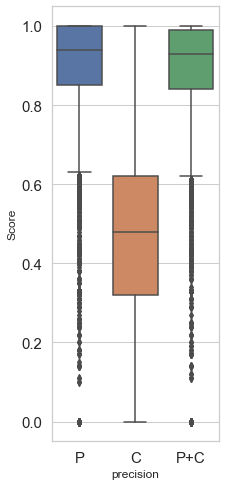

<Figure size 432x288 with 0 Axes>

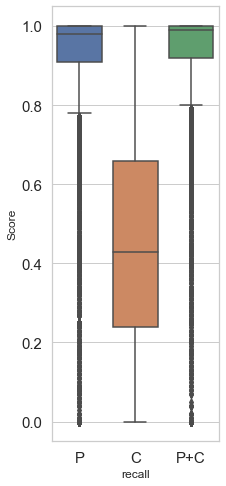

<Figure size 432x288 with 0 Axes>

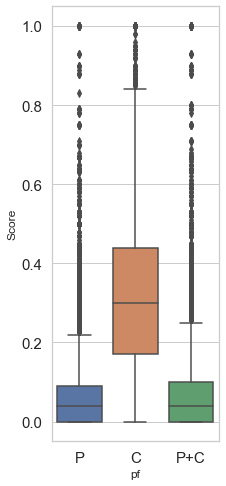

<Figure size 432x288 with 0 Axes>

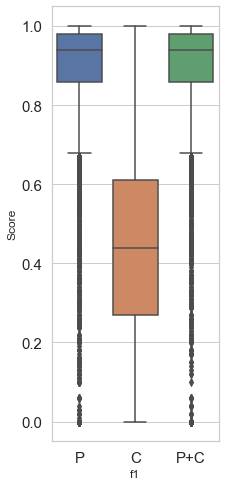

<Figure size 432x288 with 0 Axes>

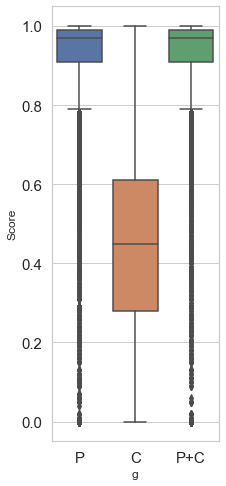

<Figure size 432x288 with 0 Axes>

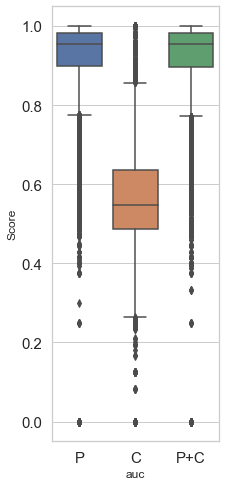

<Figure size 432x288 with 0 Axes>

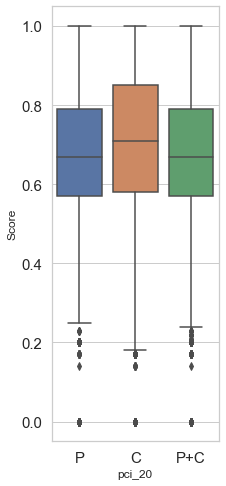

<Figure size 432x288 with 0 Axes>

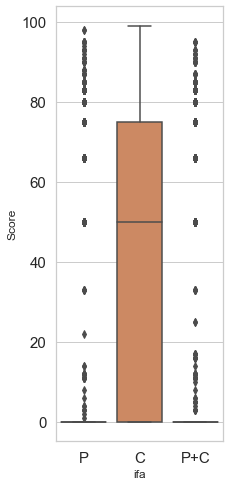

<Figure size 432x288 with 0 Axes>

In [509]:
# With file level
dfs = ['process','product','process+product']
metrics = ['precision', 'recall', 'pf', 'f1', 'g', 'auc', 'pci_20', 'ifa']
_plot = [181,182,183,184,185,186,187,188]
i = 0
for metric in metrics:
    data = []
    for df in dfs:
        file = pd.read_pickle('results/Performance/commit_guru_file_specific/' + df +'_700_rf_5_fold_5_repeat.pkl')
        l = [item for sublist in list(file[metric].values()) for item in sublist]
        print(metric,df,np.nanmedian(l))
        data.append(l)
    data_df = pd.DataFrame(data)
    data_df.index = [['P','C','P+C']]
    x = pd.melt(data_df.T)
    x.columns = [metric,'Score']
    
    
    i += 1
    fig, ax = plt.subplots(figsize=(3,8))
    plt.figure()
    ax = sns.boxplot(x = metric, y = 'Score',ax=ax ,data=x)
    ax.tick_params(labelsize=15)
    fig.savefig('results/image/' + metric + '.pdf')

# Venn Diagram

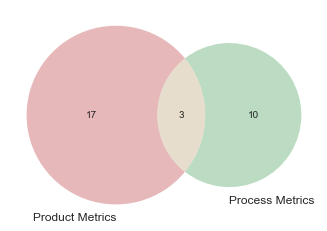

In [514]:
venn2(subsets = (17, 10, 3), set_labels = ('Product Metrics', 'Process Metrics'))

# With file level Combined image

In [521]:
dfs = ['process','product','process+product']
final_df = pd.DataFrame()
metrics = ['precision', 'recall', 'pf', 'auc', 'pci_20','ifa']
i = 0
for metric in metrics:
    data = []
    for df in dfs:
        file = pd.read_pickle('results/Performance/commit_guru_file_specific/' + df +'_700_rf_release.pkl')
        if metric == 'ifa':
            l = [item/100 for sublist in list(file[metric].values()) for item in sublist]
        else:
            l = [item for sublist in list(file[metric].values()) for item in sublist]
#         print(metric,df,np.nanmedian(l))
        data.append(l)
    data_df = pd.DataFrame(data)
    data_df.index = [['P','C','P+C']]
    x = pd.melt(data_df.T)
    x.columns = ['Metric Type','Score']
    if metric == 'pci_20':
        metric = 'popt_20'
    x['Evaluation Criteria'] = [metric]*x.shape[0]
    final_df = pd.concat([final_df,x])
final_df.columns = x.columns

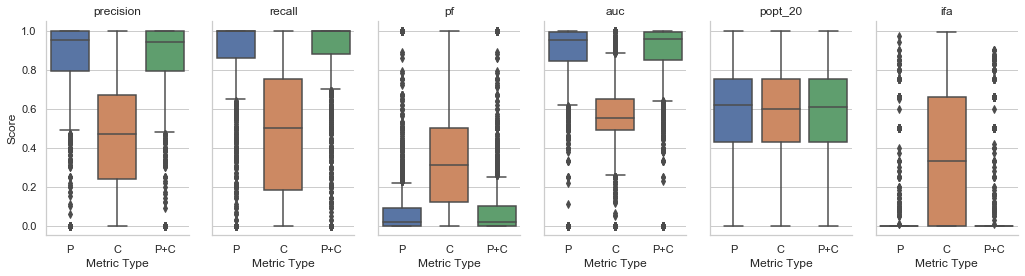

In [522]:
sns.set(style='whitegrid',font_scale=1)
order = ["P", "C", "P+C"]
g = sns.catplot(x="Metric Type", y="Score", col="Evaluation Criteria",height=4,aspect=0.6,margin_titles=True,kind="box", 
                order=order, data=final_df)
[plt.setp(ax.texts, text="") for ax in g.axes.flat]
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.savefig('results/image/RF_cross.pdf')


# Between learners

In [523]:
dfs = ['process','product','process+product']
final_df = pd.DataFrame()
learner_df = pd.DataFrame()
metrics = ['precision','ifa']
learners = ['rf','lr','nb','svc']
i = 0
for learner in learners:
    for metric in metrics:
        data = []
        for df in dfs:
            file = pd.read_pickle('results/Performance/commit_guru_file_specific/' + df +'_700_' + learner + '_5_fold_5_repeat.pkl')
            if metric == 'ifa':
                l = [item/100 for sublist in list(file[metric].values()) for item in sublist]
            else:
                l = [item for sublist in list(file[metric].values()) for item in sublist]
            data.append(l)
        data_df = pd.DataFrame(data)
        data_df.index = [['P','C','P+C']]
        x = pd.melt(data_df.T)
        x.columns = ['Metric Type','Score']
        x['Evaluation Criteria'] = [metric]*x.shape[0]
        learner_df = pd.concat([learner_df,x])
    learner_df['learner'] = [learner]*learner_df.shape[0]
    final_df = pd.concat([final_df,learner_df])


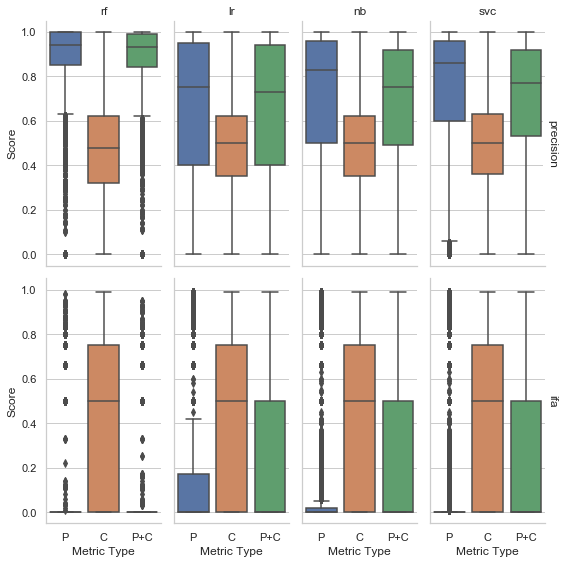

In [524]:
sns.set(style='whitegrid',font_scale=1)
order = ["P", "C", "P+C"]
g = sns.catplot(x="Metric Type", y="Score",col= 'learner' ,row="Evaluation Criteria",height=4,aspect=0.5,margin_titles=True,kind="box", 
                order=order, data=final_df)
[plt.setp(ax.texts, text="") for ax in g.axes.flat]
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.savefig('results/image/learner_56.pdf')


# Feature Importance

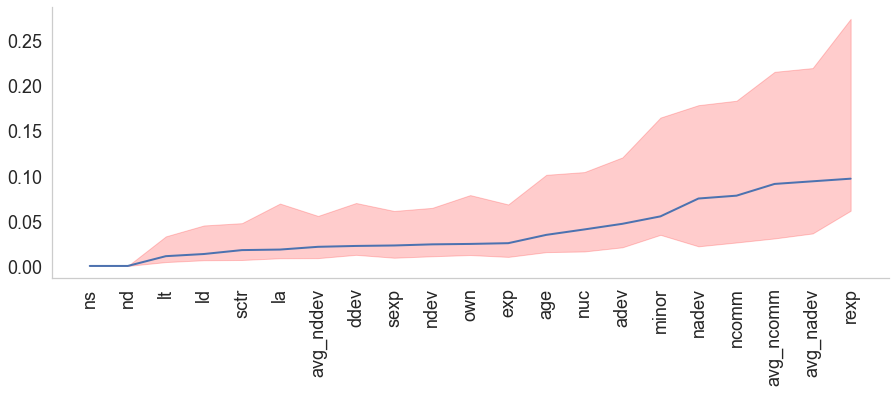

In [195]:
df = pd.read_pickle('results/Performance/commit_guru_file_specific/process_700_rf_5_fold_5_repeat.pkl')
df = df['featue_importance']
df = pd.DataFrame.from_dict(df,orient='index')
df.columns = ['la', 'ld', 'lt', 'age', 'ddev',
       'nuc', 'own', 'minor', 'ndev', 'ncomm', 'adev',
       'nadev', 'avg_nddev', 'avg_nadev', 'avg_ncomm',
       'ns', 'exp', 'sexp', 'rexp', 'nd', 'sctr']
df_stats = pd.DataFrame(df.quantile([.25, .5, .75]))
df_stats = df_stats.T
df_stats.columns = ['25th','50th','75th']
df_stats = df_stats.sort_values(by = ['50th'])
x = range(0,21)
y1 = np.array(df_stats['25th'].values.tolist())
y2 = np.array(df_stats['50th'].values.tolist())
y3 = np.array(df_stats['75th'].values.tolist())
fig, ax = plt.subplots(figsize=(15,5))
ax.set_xticks(x)
ax.plot(y2,linestyle='-', color='b', linewidth='2')
ax.set_xticklabels(df_stats.index.tolist())
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.fill_between(x, y2 - y1, y2 + y3, alpha=0.2,color='red')
plt.xticks(fontsize=18,rotation=90)
plt.yticks(fontsize=18)
plt.grid(b=None)
plt.savefig('results/image/process_feature.pdf',dpi=600,bbox_inches='tight', pad_inches=0.3)

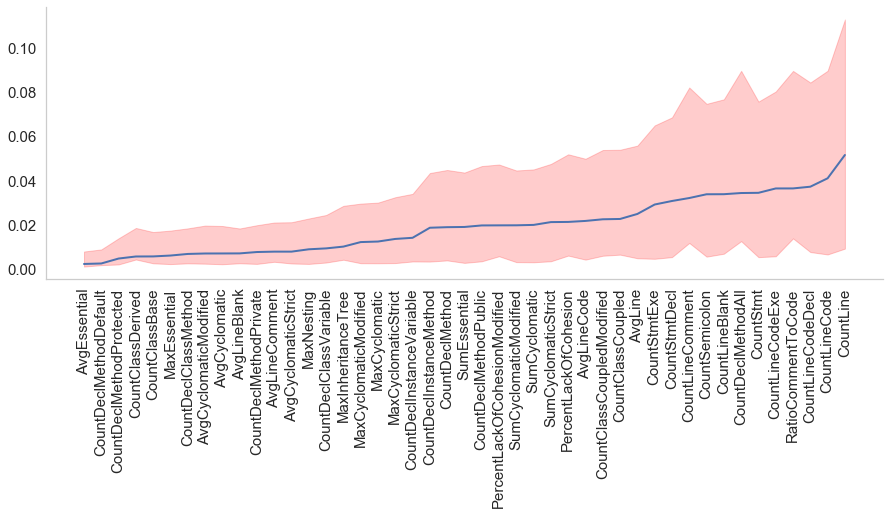

In [194]:
df = pd.read_pickle('results/Performance/commit_guru_file_specific/product_700_rf_5_fold_5_repeat.pkl')
df = df['featue_importance']
df = pd.DataFrame.from_dict(df,orient='index')
df.columns = ['AvgCyclomatic', 'AvgCyclomaticModified', 'AvgCyclomaticStrict',
       'AvgEssential', 'AvgLine', 'AvgLineBlank', 'AvgLineCode',
       'AvgLineComment', 'CountClassBase', 'CountClassCoupled',
       'CountClassCoupledModified', 'CountClassDerived',
       'CountDeclClassMethod', 'CountDeclClassVariable',
       'CountDeclInstanceMethod', 'CountDeclInstanceVariable',
       'CountDeclMethod', 'CountDeclMethodAll', 'CountDeclMethodDefault',
       'CountDeclMethodPrivate', 'CountDeclMethodProtected',
       'CountDeclMethodPublic', 'CountLine', 'CountLineBlank', 'CountLineCode',
       'CountLineCodeDecl', 'CountLineCodeExe', 'CountLineComment',
       'CountSemicolon', 'CountStmt', 'CountStmtDecl', 'CountStmtExe',
       'MaxCyclomatic', 'MaxCyclomaticModified', 'MaxCyclomaticStrict',
       'MaxEssential', 'MaxInheritanceTree', 'MaxNesting',
       'PercentLackOfCohesion', 'PercentLackOfCohesionModified',
       'RatioCommentToCode', 'SumCyclomatic', 'SumCyclomaticModified',
       'SumCyclomaticStrict', 'SumEssential']
df_stats = pd.DataFrame(df.quantile([.25, .5, .75]))
df_stats = df_stats.T
df_stats.columns = ['25th','50th','75th']
df_stats = df_stats.sort_values(by = ['50th'])
x = range(0,45)
y1 = np.array(df_stats['25th'].values.tolist())
y2 = np.array(df_stats['50th'].values.tolist())
y3 = np.array(df_stats['75th'].values.tolist())
fig, ax = plt.subplots(figsize=(15,5))
ax.set_xticks(x)
ax.plot(y2,linestyle='-', color='b', linewidth='2')
ax.set_xticklabels(df_stats.index.tolist())
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.fill_between(x, y2 - y1, y2 + y3, alpha=0.2,color='red')
plt.xticks(fontsize=15,rotation=90)
plt.yticks(fontsize=15)
plt.grid(b=None)
plt.savefig('results/image/product_feature.pdf',dpi=600,bbox_inches='tight', pad_inches=0.3)

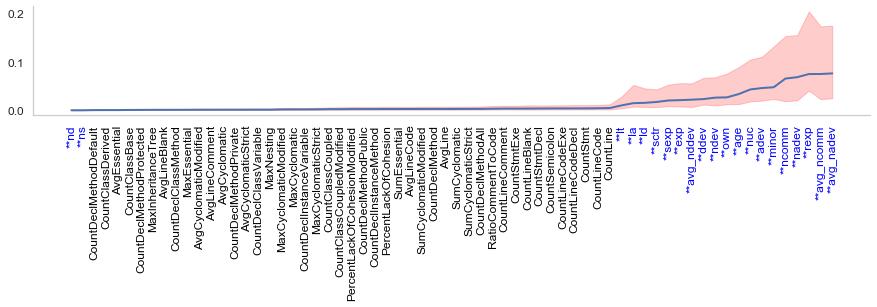

In [559]:
df = pd.read_pickle('results/Performance/commit_guru_file_specific/process+product_700_rf_5_fold_5_repeat.pkl')
df = df['featue_importance']
df = pd.DataFrame.from_dict(df,orient='index')
df.columns = ['AvgCyclomatic', 'AvgCyclomaticModified', 'AvgCyclomaticStrict',
       'AvgEssential', 'AvgLine', 'AvgLineBlank', 'AvgLineCode',
       'AvgLineComment', 'CountClassBase', 'CountClassCoupled',
       'CountClassCoupledModified', 'CountClassDerived',
       'CountDeclClassMethod', 'CountDeclClassVariable',
       'CountDeclInstanceMethod', 'CountDeclInstanceVariable',
       'CountDeclMethod', 'CountDeclMethodAll', 'CountDeclMethodDefault',
       'CountDeclMethodPrivate', 'CountDeclMethodProtected',
       'CountDeclMethodPublic', 'CountLine', 'CountLineBlank', 'CountLineCode',
       'CountLineCodeDecl', 'CountLineCodeExe', 'CountLineComment',
       'CountSemicolon', 'CountStmt', 'CountStmtDecl', 'CountStmtExe',
       'MaxCyclomatic', 'MaxCyclomaticModified', 'MaxCyclomaticStrict',
       'MaxEssential', 'MaxInheritanceTree', 'MaxNesting',
       'PercentLackOfCohesion', 'PercentLackOfCohesionModified',
       'RatioCommentToCode', 'SumCyclomatic', 'SumCyclomaticModified',
       'SumCyclomaticStrict', 'SumEssential', 'la', 'ld', 'lt',
       'age', 'ddev', 'nuc', 'own', 'minor', 'ndev',
       'ncomm', 'adev', 'nadev', 'avg_nddev',
       'avg_nadev', 'avg_ncomm', 'ns', 'exp', 'sexp',
       'rexp', 'nd', 'sctr']
df_stats = pd.DataFrame(df.quantile([.25, .5, .75]))
df_stats = df_stats.T
df_stats.columns = ['25th','50th','75th']
df_stats = df_stats.sort_values(by = ['50th'])
x = range(0,66)
y1 = np.array(df_stats['25th'].values.tolist())
y2 = np.array(df_stats['50th'].values.tolist())
y3 = np.array(df_stats['75th'].values.tolist())
fig, ax = plt.subplots(figsize=(15,2))
# ax.set_ylim(0,0.25)
# ax.set_xlim(66, 0)
ax.set_xticks(x)
ax.plot(y2,linestyle='-', color='b', linewidth='2')

_x_tick = ['**nd', '**ns', 'CountDeclMethodDefault', 'CountClassDerived', 'AvgEssential', 
'CountClassBase', 'CountDeclMethodProtected', 'MaxInheritanceTree', 'AvgLineBlank', 
'CountDeclClassMethod', 'MaxEssential', 'AvgCyclomaticModified', 'AvgLineComment', 
'AvgCyclomatic', 'CountDeclMethodPrivate', 'AvgCyclomaticStrict', 'CountDeclClassVariable', 
'MaxNesting', 'MaxCyclomaticModified', 'MaxCyclomatic', 'CountDeclInstanceVariable', 
'MaxCyclomaticStrict', 'CountClassCoupled', 'CountClassCoupledModified', 
'PercentLackOfCohesionModified', 'CountDeclMethodPublic', 'CountDeclInstanceMethod', 
'PercentLackOfCohesion', 'SumEssential', 'AvgLineCode', 'SumCyclomaticModified', 
'CountDeclMethod', 'AvgLine', 'SumCyclomatic', 'SumCyclomaticStrict', 
'CountDeclMethodAll', 'RatioCommentToCode', 'CountLineComment', 
'CountStmtExe', 'CountLineBlank', 'CountStmtDecl', 'CountSemicolon', 
'CountLineCodeExe', 'CountLineCodeDecl', 'CountStmt', 'CountLineCode', 
'CountLine', '**lt', '**la', '**ld', '**sctr', '**sexp', '**exp', '**avg_nddev', '**ddev', '**ndev', 
'**own', '**age', '**nuc', '**adev', '**minor', '**ncomm', '**nadev', '**rexp', '**avg_ncomm', '**avg_nadev']

ax.set_xticklabels(_x_tick)

colors = []
process = ['**la', '**ld', '**lt',
       '**age', '**ddev', '**nuc', '**own', '**minor', '**ndev',
       '**ncomm', '**adev', '**nadev', '**avg_nddev',
       '**avg_nadev', '**avg_ncomm', '**ns', '**exp', '**sexp',
       '**rexp', '**nd', '**sctr']

for tick in _x_tick:
    if tick in process:
        colors.append('blue')
    else:
        colors.append('black')

for xtick, color in zip(ax.get_xticklabels(), colors):
    xtick.set_color(color)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.fill_between(x, y2 - y1, y2 + y3, alpha=0.2,color='red')
plt.xticks(fontsize=12,rotation=90)
plt.yticks(fontsize=12)
plt.grid(b=None)
plt.savefig('results/image/process+product_feature.pdf',dpi=600,bbox_inches='tight', pad_inches=0.3)

# LR Coefs

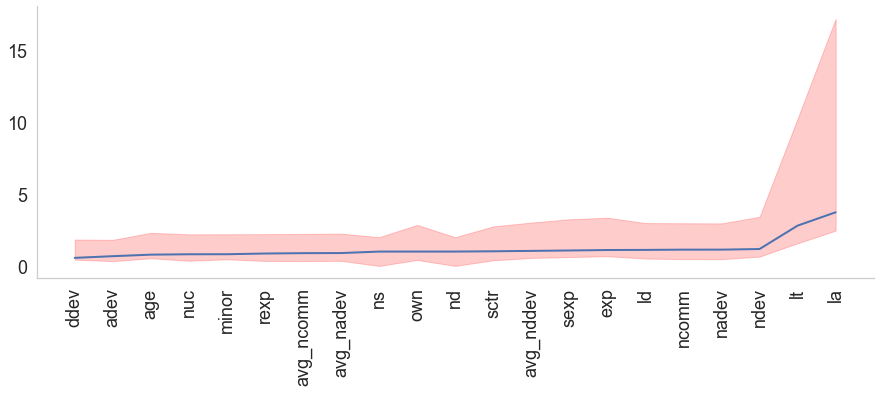

In [243]:
df = pd.read_pickle('results/Performance/commit_guru_file_specific/process_700_lr_5_fold_5_repeat_feature.pkl')
df = df['featue_importance']
for key in df.keys():
    df[key] = df[key][0]
df = pd.DataFrame.from_dict(df,orient='index')
df.columns = ['la', 'ld', 'lt', 'age', 'ddev',
       'nuc', 'own', 'minor', 'ndev', 'ncomm', 'adev',
       'nadev', 'avg_nddev', 'avg_nadev', 'avg_ncomm',
       'ns', 'exp', 'sexp', 'rexp', 'nd', 'sctr']
df_stats = pd.DataFrame(df.quantile([.25, .5, .75]))
df_stats = df_stats.T
df_stats.columns = ['25th','50th','75th']
df_stats = df_stats.apply(np.vectorize(math.exp))
df_stats = df_stats.sort_values(by = ['50th'])
x = range(0,21)
y1 = np.array(df_stats['25th'].values.tolist())
y2 = np.array(df_stats['50th'].values.tolist())
y3 = np.array(df_stats['75th'].values.tolist())
fig, ax = plt.subplots(figsize=(15,5))
ax.set_xticks(x)
ax.plot(y2,linestyle='-', color='b', linewidth='2')
ax.set_xticklabels(df_stats.index.tolist())
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.fill_between(x, y2 - y1, y2 + y3, alpha=0.2,color='red')
plt.xticks(fontsize=18,rotation=90)
plt.yticks(fontsize=18)
plt.grid(b=None)
# plt.savefig('results/image/process_feature.pdf',dpi=600,bbox_inches='tight', pad_inches=0.3)

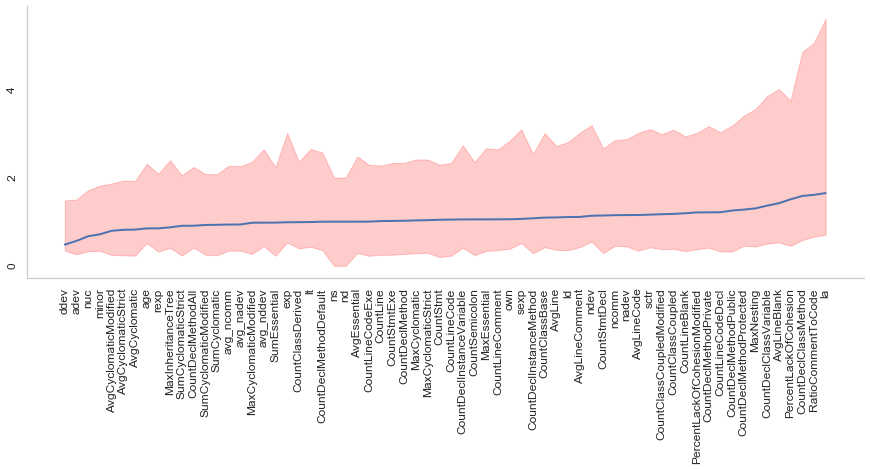

In [305]:
df = pd.read_pickle('results/Performance/commit_guru_file_specific/process+product_700_lr_5_fold_5_repeat_feature.pkl')
df = df['featue_importance']
for key in df.keys():
    df[key] = df[key][0]
df = pd.DataFrame.from_dict(df,orient='index')
df.columns = ['AvgCyclomatic', 'AvgCyclomaticModified', 'AvgCyclomaticStrict',
       'AvgEssential', 'AvgLine', 'AvgLineBlank', 'AvgLineCode',
       'AvgLineComment', 'CountClassBase', 'CountClassCoupled',
       'CountClassCoupledModified', 'CountClassDerived',
       'CountDeclClassMethod', 'CountDeclClassVariable',
       'CountDeclInstanceMethod', 'CountDeclInstanceVariable',
       'CountDeclMethod', 'CountDeclMethodAll', 'CountDeclMethodDefault',
       'CountDeclMethodPrivate', 'CountDeclMethodProtected',
       'CountDeclMethodPublic', 'CountLine', 'CountLineBlank', 'CountLineCode',
       'CountLineCodeDecl', 'CountLineCodeExe', 'CountLineComment',
       'CountSemicolon', 'CountStmt', 'CountStmtDecl', 'CountStmtExe',
       'MaxCyclomatic', 'MaxCyclomaticModified', 'MaxCyclomaticStrict',
       'MaxEssential', 'MaxInheritanceTree', 'MaxNesting',
       'PercentLackOfCohesion', 'PercentLackOfCohesionModified',
       'RatioCommentToCode', 'SumCyclomatic', 'SumCyclomaticModified',
       'SumCyclomaticStrict', 'SumEssential', 'la', 'ld', 'lt',
       'age', 'ddev', 'nuc', 'own', 'minor', 'ndev',
       'ncomm', 'adev', 'nadev', 'avg_nddev',
       'avg_nadev', 'avg_ncomm', 'ns', 'exp', 'sexp',
       'rexp', 'nd', 'sctr']
df_stats = pd.DataFrame(df.quantile([.25, .5, .75]))
df_stats = df_stats.T
df_stats.columns = ['25th','50th','75th']
df_stats = df_stats.apply(np.vectorize(math.exp))
df_stats = df_stats.sort_values(by = ['50th'])
x = range(0,66)
y1 = np.array(df_stats['25th'].values.tolist())
y2 = np.array(df_stats['50th'].values.tolist())
y3 = np.array(df_stats['75th'].values.tolist())
fig, ax = plt.subplots(figsize=(15,5))
ax.set_xticks(x)
ax.plot(y2,linestyle='-', color='b', linewidth='2')
ax.set_xticklabels(df_stats.index.tolist())
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.fill_between(x, y2 - y1, y2 + y3, alpha=0.2,color='red')
plt.xticks(fontsize=12,rotation=90)
plt.yticks(fontsize=12,rotation=90)
plt.grid(b=None)
plt.savefig('results/image/process+product_feature_lr.pdf',dpi=600,bbox_inches='tight', pad_inches=0.3)

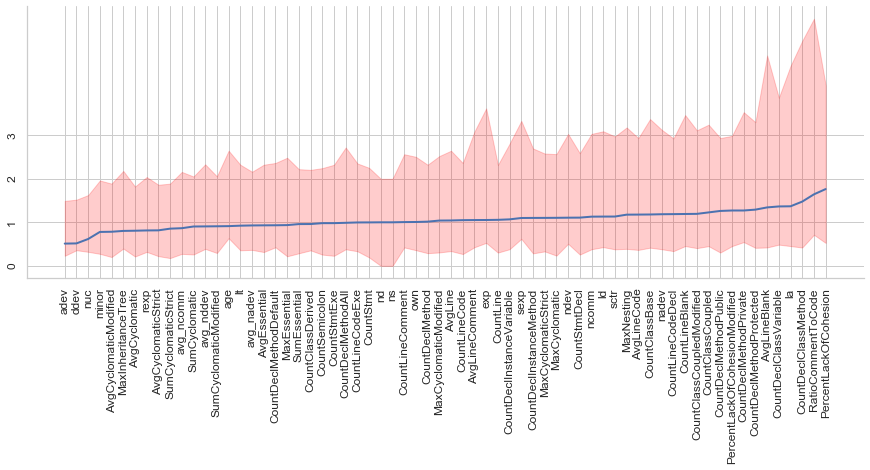

In [401]:
df = pd.read_pickle('results/Performance/commit_guru_file_specific/process+product_700_lr_5_fold_5_repeat_feature.pkl')
df = df['featue_importance']
for key in df.keys():
    df[key] = df[key][0]
df = pd.DataFrame.from_dict(df,orient='index')
df.columns = ['AvgCyclomatic', 'AvgCyclomaticModified', 'AvgCyclomaticStrict',
       'AvgEssential', 'AvgLine', 'AvgLineBlank', 'AvgLineCode',
       'AvgLineComment', 'CountClassBase', 'CountClassCoupled',
       'CountClassCoupledModified', 'CountClassDerived',
       'CountDeclClassMethod', 'CountDeclClassVariable',
       'CountDeclInstanceMethod', 'CountDeclInstanceVariable',
       'CountDeclMethod', 'CountDeclMethodAll', 'CountDeclMethodDefault',
       'CountDeclMethodPrivate', 'CountDeclMethodProtected',
       'CountDeclMethodPublic', 'CountLine', 'CountLineBlank', 'CountLineCode',
       'CountLineCodeDecl', 'CountLineCodeExe', 'CountLineComment',
       'CountSemicolon', 'CountStmt', 'CountStmtDecl', 'CountStmtExe',
       'MaxCyclomatic', 'MaxCyclomaticModified', 'MaxCyclomaticStrict',
       'MaxEssential', 'MaxInheritanceTree', 'MaxNesting',
       'PercentLackOfCohesion', 'PercentLackOfCohesionModified',
       'RatioCommentToCode', 'SumCyclomatic', 'SumCyclomaticModified',
       'SumCyclomaticStrict', 'SumEssential', 'la', 'ld', 'lt',
       'age', 'ddev', 'nuc', 'own', 'minor', 'ndev',
       'ncomm', 'adev', 'nadev', 'avg_nddev',
       'avg_nadev', 'avg_ncomm', 'ns', 'exp', 'sexp',
       'rexp', 'nd', 'sctr']
df_new = pd.DataFrame()
for i in range(20):
    _df = df.sample(n = 5)
    df_new = pd.concat([df_new,_df],axis = 0)
df_stats = pd.DataFrame(df_new.quantile([.25, .5, .75]))
df_stats = df_stats.T
df_stats.columns = ['25th','50th','75th']
df_stats = df_stats.apply(np.vectorize(math.exp))
df_stats = df_stats.sort_values(by = ['50th'])
x = range(0,66)
y = range(0,4)
y1 = np.array(df_stats['25th'].values.tolist())
y2 = np.array(df_stats['50th'].values.tolist())
y3 = np.array(df_stats['75th'].values.tolist())
fig, ax = plt.subplots(figsize=(15,5))
ax.set_xticks(x)
ax.set_yticks(y)
ax.plot(y2,linestyle='-', color='b', linewidth='2')
ax.set_xticklabels(df_stats.index.tolist())
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.fill_between(x, y2 - y1, y2 + y3, alpha=0.2,color='red')
plt.xticks(fontsize=12,rotation=90)
plt.yticks(fontsize=12,rotation=90)
# plt.grid(b=None)
plt.savefig('results/image/process+product_feature_lr.pdf',dpi=600,bbox_inches='tight', pad_inches=0.3)

# Rank Compare Process

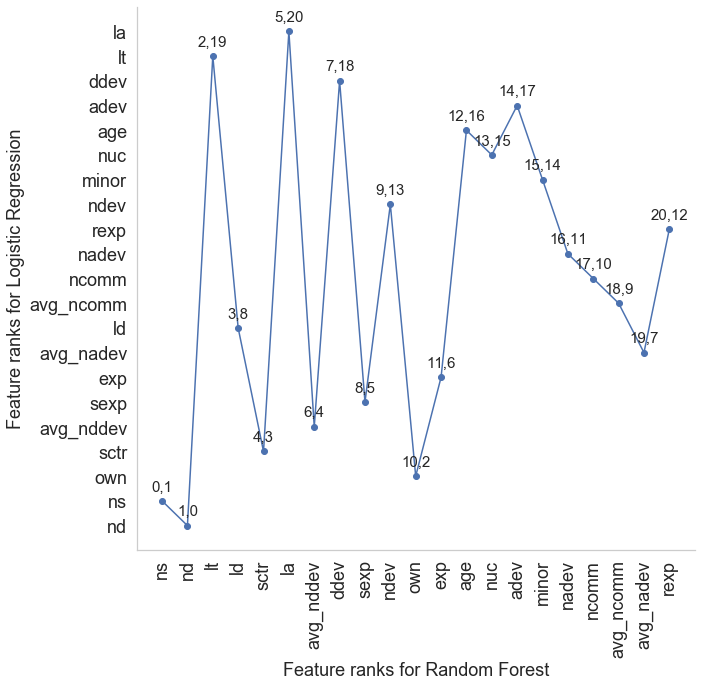

In [560]:
df = pd.read_pickle('results/Performance/commit_guru_file_specific/process_700_rf_5_fold_5_repeat.pkl')
df = df['featue_importance']
df = pd.DataFrame.from_dict(df,orient='index')
df.columns = ['la', 'ld', 'lt', 'age', 'ddev',
       'nuc', 'own', 'minor', 'ndev', 'ncomm', 'adev',
       'nadev', 'avg_nddev', 'avg_nadev', 'avg_ncomm',
       'ns', 'exp', 'sexp', 'rexp', 'nd', 'sctr']
df_stats = pd.DataFrame(df.quantile([.25, .5, .75]))
df_stats = df_stats.T
df_stats.columns = ['25th','50th','75th']
df_stats_rf = df_stats.sort_values(by = ['50th'])
df_stats_rf['rank_rf'] = range(0,21)
df_stats_rf = df_stats_rf.drop(['25th','50th','75th'],axis = 1)
# df_stats_rf = df_stats_lr.reset_index()
df = pd.read_pickle('results/Performance/commit_guru_file_specific/process_700_lr_5_fold_5_repeat_feature.pkl')
df = df['featue_importance']
for key in df.keys():
    df[key] = df[key][0]
df = pd.DataFrame.from_dict(df,orient='index')
df.columns = ['la', 'ld', 'lt', 'age', 'ddev',
       'nuc', 'own', 'minor', 'ndev', 'ncomm', 'adev',
       'nadev', 'avg_nddev', 'avg_nadev', 'avg_ncomm',
       'ns', 'exp', 'sexp', 'rexp', 'nd', 'sctr']
df_stats = pd.DataFrame(df.quantile([.25, .5, .75]))
df_stats = df_stats.T
df_stats.columns = ['25th','50th','75th']
df_stats = df_stats.apply(np.vectorize(abs))
df_stats = df_stats.apply(np.vectorize(math.exp))
df_stats_lr = df_stats.sort_values(by = ['50th'])
df_stats_lr['rank_lr'] = range(0,21)
df_stats_lr = df_stats_lr.drop(['25th','50th','75th'],axis = 1)
new_df = df_stats_rf.join(df_stats_lr)

x = range(0,21)
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xticks(x)
ax.set_yticks(x)
plt.plot(new_df.rank_rf,new_df.rank_lr,marker='o', color='b')
ax.set_xticklabels(new_df.index.tolist())
plt.xticks(fontsize=18,rotation=90)
ax.set_yticklabels(df_stats_lr.index.tolist())
plt.yticks(fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid(b=None)
ax.set_xlabel('Feature ranks for Random Forest',fontsize=18)
ax.set_ylabel('Feature ranks for Logistic Regression',fontsize=18)
for x,y in zip(new_df.rank_rf,new_df.rank_lr):

    label = "{:d},{:d}".format(x,y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',fontsize=15)
plt.savefig('results/image/ranks_process.pdf',dpi=600,bbox_inches='tight', pad_inches=0.3)

# Rank Compare Product+Process

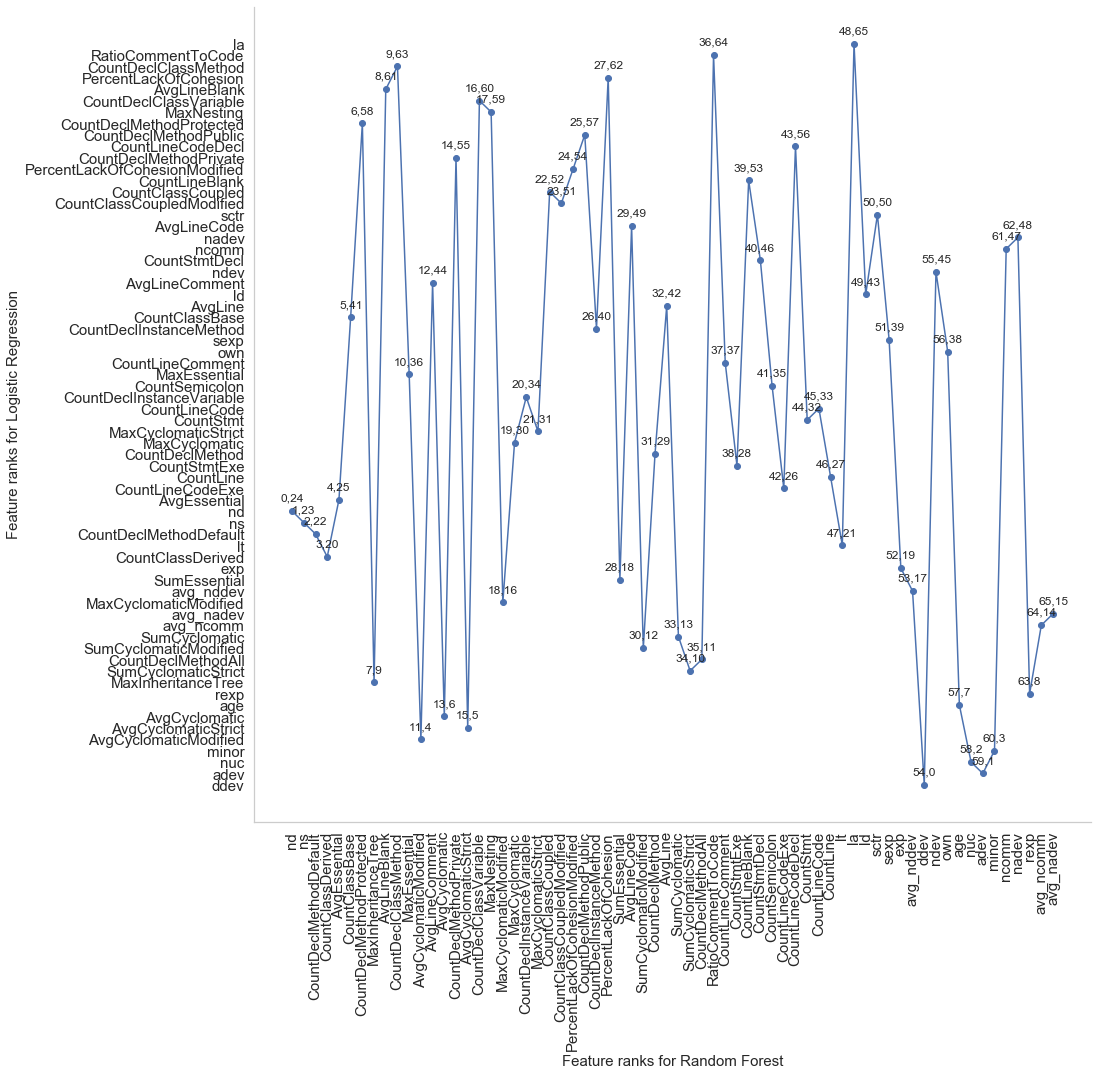

In [378]:
df = pd.read_pickle('results/Performance/commit_guru_file_specific/process+product_700_rf_5_fold_5_repeat.pkl')
df = df['featue_importance']
df = pd.DataFrame.from_dict(df,orient='index')
df.columns = ['AvgCyclomatic', 'AvgCyclomaticModified', 'AvgCyclomaticStrict',
       'AvgEssential', 'AvgLine', 'AvgLineBlank', 'AvgLineCode',
       'AvgLineComment', 'CountClassBase', 'CountClassCoupled',
       'CountClassCoupledModified', 'CountClassDerived',
       'CountDeclClassMethod', 'CountDeclClassVariable',
       'CountDeclInstanceMethod', 'CountDeclInstanceVariable',
       'CountDeclMethod', 'CountDeclMethodAll', 'CountDeclMethodDefault',
       'CountDeclMethodPrivate', 'CountDeclMethodProtected',
       'CountDeclMethodPublic', 'CountLine', 'CountLineBlank', 'CountLineCode',
       'CountLineCodeDecl', 'CountLineCodeExe', 'CountLineComment',
       'CountSemicolon', 'CountStmt', 'CountStmtDecl', 'CountStmtExe',
       'MaxCyclomatic', 'MaxCyclomaticModified', 'MaxCyclomaticStrict',
       'MaxEssential', 'MaxInheritanceTree', 'MaxNesting',
       'PercentLackOfCohesion', 'PercentLackOfCohesionModified',
       'RatioCommentToCode', 'SumCyclomatic', 'SumCyclomaticModified',
       'SumCyclomaticStrict', 'SumEssential', 'la', 'ld', 'lt',
       'age', 'ddev', 'nuc', 'own', 'minor', 'ndev',
       'ncomm', 'adev', 'nadev', 'avg_nddev',
       'avg_nadev', 'avg_ncomm', 'ns', 'exp', 'sexp',
       'rexp', 'nd', 'sctr']
df_stats = pd.DataFrame(df.quantile([.25, .5, .75]))
df_stats = df_stats.T
df_stats.columns = ['25th','50th','75th']
df_stats_rf = df_stats.sort_values(by = ['50th'])
df_stats_rf['rank_rf'] = range(0,66)
df_stats_rf = df_stats_rf.drop(['25th','50th','75th'],axis = 1)
# df_stats_rf = df_stats_lr.reset_index()
df = pd.read_pickle('results/Performance/commit_guru_file_specific/process+product_700_lr_5_fold_5_repeat_feature.pkl')
df = df['featue_importance']
for key in df.keys():
    df[key] = df[key][0]
df = pd.DataFrame.from_dict(df,orient='index')
df.columns = ['AvgCyclomatic', 'AvgCyclomaticModified', 'AvgCyclomaticStrict',
       'AvgEssential', 'AvgLine', 'AvgLineBlank', 'AvgLineCode',
       'AvgLineComment', 'CountClassBase', 'CountClassCoupled',
       'CountClassCoupledModified', 'CountClassDerived',
       'CountDeclClassMethod', 'CountDeclClassVariable',
       'CountDeclInstanceMethod', 'CountDeclInstanceVariable',
       'CountDeclMethod', 'CountDeclMethodAll', 'CountDeclMethodDefault',
       'CountDeclMethodPrivate', 'CountDeclMethodProtected',
       'CountDeclMethodPublic', 'CountLine', 'CountLineBlank', 'CountLineCode',
       'CountLineCodeDecl', 'CountLineCodeExe', 'CountLineComment',
       'CountSemicolon', 'CountStmt', 'CountStmtDecl', 'CountStmtExe',
       'MaxCyclomatic', 'MaxCyclomaticModified', 'MaxCyclomaticStrict',
       'MaxEssential', 'MaxInheritanceTree', 'MaxNesting',
       'PercentLackOfCohesion', 'PercentLackOfCohesionModified',
       'RatioCommentToCode', 'SumCyclomatic', 'SumCyclomaticModified',
       'SumCyclomaticStrict', 'SumEssential', 'la', 'ld', 'lt',
       'age', 'ddev', 'nuc', 'own', 'minor', 'ndev',
       'ncomm', 'adev', 'nadev', 'avg_nddev',
       'avg_nadev', 'avg_ncomm', 'ns', 'exp', 'sexp',
       'rexp', 'nd', 'sctr']
df_stats = pd.DataFrame(df.quantile([.25, .5, .75]))
df_stats = df_stats.T
df_stats.columns = ['25th','50th','75th']
df_stats = df_stats.apply(np.vectorize(math.exp))
df_stats_lr = df_stats.sort_values(by = ['50th'])
df_stats_lr['rank_lr'] = range(0,66)
df_stats_lr = df_stats_lr.drop(['25th','50th','75th'],axis = 1)
new_df = df_stats_rf.join(df_stats_lr)

x = range(0,66)
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks(x)
ax.set_yticks(x)
plt.plot(new_df.rank_rf,new_df.rank_lr,marker='o', color='b')
ax.set_xticklabels(new_df.index.tolist())
plt.xticks(fontsize=15,rotation=90)
ax.set_yticklabels(df_stats_lr.index.tolist())
plt.yticks(fontsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid(b=None)
ax.set_xlabel('Feature ranks for Random Forest',fontsize=15)
ax.set_ylabel('Feature ranks for Logistic Regression',fontsize=15)
for x,y in zip(new_df.rank_rf,new_df.rank_lr):

    label = "{:d},{:d}".format(x,y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',fontsize=12)
plt.savefig('results/image/ranks_process+product.pdf',dpi=600,bbox_inches='tight', pad_inches=0.3)


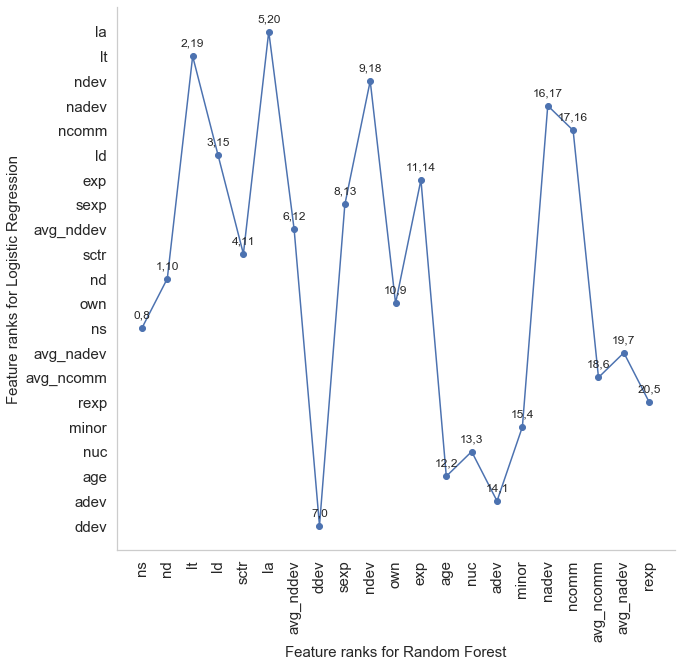

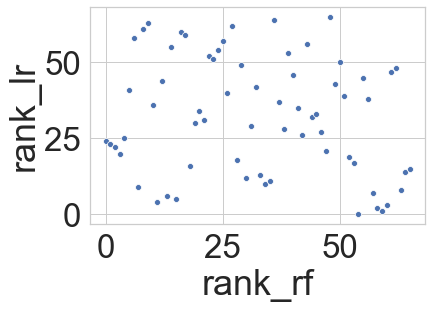

In [336]:
sns.scatterplot(x="rank_rf", y="rank_lr", data=new_df)

In [379]:
df = pd.read_pickle('results/Performance/commit_guru_file_specific/process+product_700_lr_5_fold_5_repeat_feature.pkl')
df = df['featue_importance']
for key in df.keys():
    df[key] = df[key][0]
df = pd.DataFrame.from_dict(df,orient='index')
df.columns = ['AvgCyclomatic', 'AvgCyclomaticModified', 'AvgCyclomaticStrict',
       'AvgEssential', 'AvgLine', 'AvgLineBlank', 'AvgLineCode',
       'AvgLineComment', 'CountClassBase', 'CountClassCoupled',
       'CountClassCoupledModified', 'CountClassDerived',
       'CountDeclClassMethod', 'CountDeclClassVariable',
       'CountDeclInstanceMethod', 'CountDeclInstanceVariable',
       'CountDeclMethod', 'CountDeclMethodAll', 'CountDeclMethodDefault',
       'CountDeclMethodPrivate', 'CountDeclMethodProtected',
       'CountDeclMethodPublic', 'CountLine', 'CountLineBlank', 'CountLineCode',
       'CountLineCodeDecl', 'CountLineCodeExe', 'CountLineComment',
       'CountSemicolon', 'CountStmt', 'CountStmtDecl', 'CountStmtExe',
       'MaxCyclomatic', 'MaxCyclomaticModified', 'MaxCyclomaticStrict',
       'MaxEssential', 'MaxInheritanceTree', 'MaxNesting',
       'PercentLackOfCohesion', 'PercentLackOfCohesionModified',
       'RatioCommentToCode', 'SumCyclomatic', 'SumCyclomaticModified',
       'SumCyclomaticStrict', 'SumEssential', 'la', 'ld', 'lt',
       'age', 'ddev', 'nuc', 'own', 'minor', 'ndev',
       'ncomm', 'adev', 'nadev', 'avg_nddev',
       'avg_nadev', 'avg_ncomm', 'ns', 'exp', 'sexp',
       'rexp', 'nd', 'sctr']
df_stats = pd.DataFrame(df.quantile([.25, .5, .75]))
df_stats = df_stats.T
df_stats.columns = ['25th','50th','75th']
df_stats = df_stats.apply(np.vectorize(math.exp))
df_stats_lr = df_stats.sort_values(by = ['50th'])


In [396]:
np.std(df_stats_lr['50th'].values)

0.21264489129805528

In [398]:
np.median(df_stats_lr['50th'].values) + np.std(df_stats_lr['50th'].values)

1.2585378742047435

# variability Within Each project 

In [470]:
file_rf = pd.read_pickle('results/Performance/commit_guru_file_specific/process_700_rf_5_fold_5_repeat.pkl')
file_lr = pd.read_pickle('results/Performance/commit_guru_file_specific/process_700_lr_5_fold_5_repeat.pkl')

file_rf = file_rf['auc']
file_lr = file_lr['auc']

rf_df = pd.DataFrame.from_dict(file_rf,orient='index')
lr_df = pd.DataFrame.from_dict(file_lr,orient='index')

rf_df = pd.DataFrame(rf_df.quantile([.0, .5, .1],axis = 1))
lr_df = pd.DataFrame(lr_df.quantile([.0, .5, .1],axis = 1))

rf_df = rf_df.T
lr_df = lr_df.T

rf_df.columns = ['25th','50th','75th']
lr_df.columns = ['25th','50th','75th']

rf_df['IQR_rf'] = rf_df['75th'] - rf_df['25th']
lr_df['IQR_lr'] = lr_df['75th'] - lr_df['25th']

rf_df = rf_df.drop(['25th','50th','75th'],axis=1)
lr_df = lr_df.drop(['25th','50th','75th'],axis=1)

In [471]:
new_df = pd.concat([lr_df,rf_df],axis = 1)
new_df = new_df.dropna()

In [472]:
new_df = new_df.sort_values('IQR_rf')

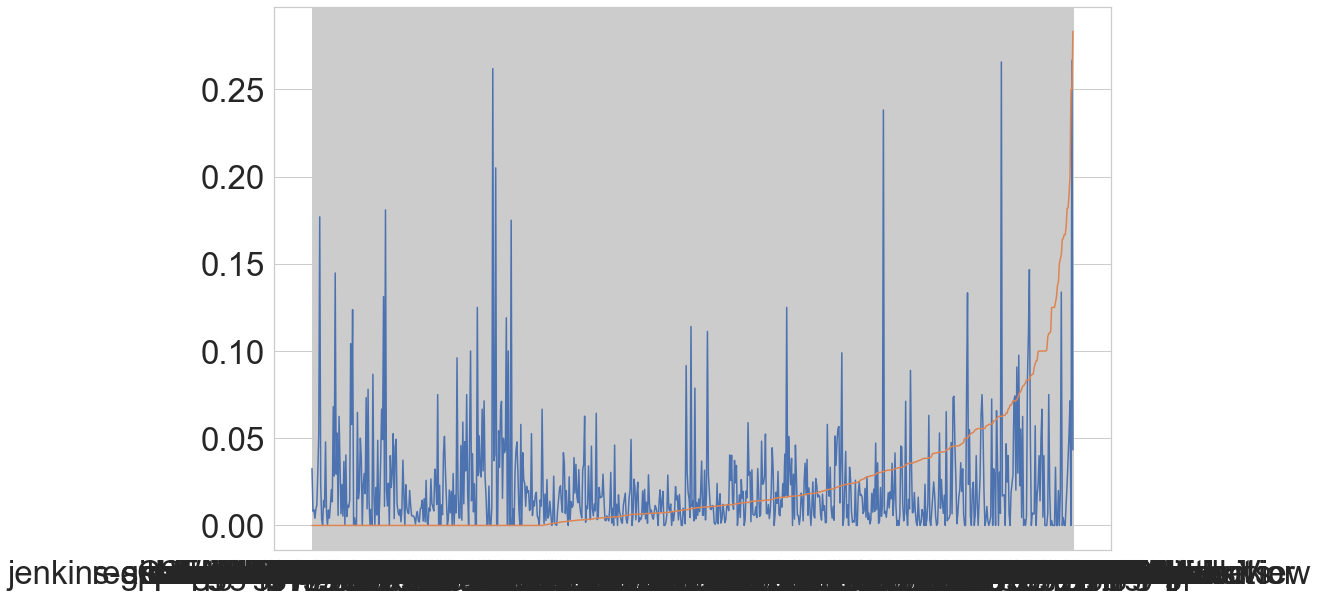

In [473]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(new_df)

In [494]:
file_rf = pd.read_pickle('results/Performance/commit_guru_file_specific/process_700_rf_5_fold_5_repeat.pkl')
file_lr = pd.read_pickle('results/Performance/commit_guru_file_specific/process_700_lr_5_fold_5_repeat.pkl')

file_rf = file_rf['recall']
file_lr = file_lr['recall']

rf_df = pd.DataFrame.from_dict(file_rf,orient='index')
lr_df = pd.DataFrame.from_dict(file_lr,orient='index')

rf_df = pd.DataFrame(rf_df.quantile([.25, .5, .75],axis = 1))
rf_df = rf_df.T
rf_df.columns = ['25th','50th','75th']
rf_df = rf_df.sort_values('50th')

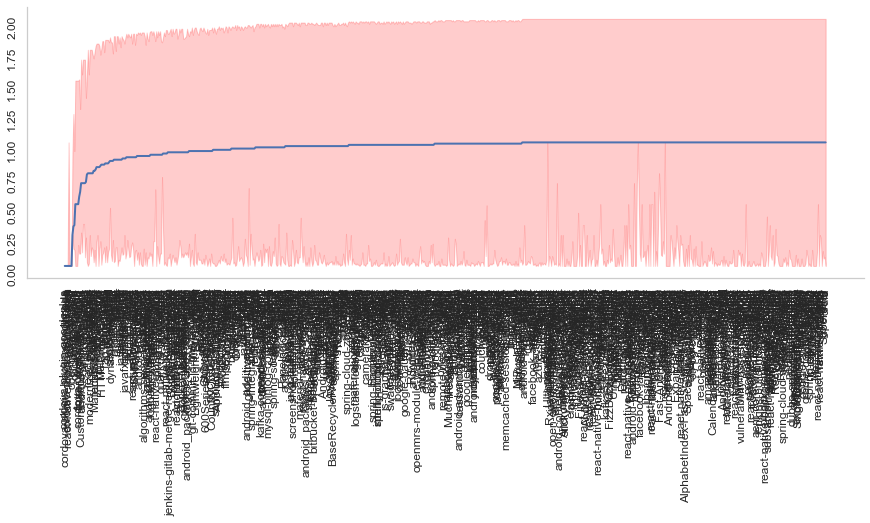

In [511]:
x = range(rf_df.shape[0])
y1 = np.array(rf_df['25th'].values.tolist())
y2 = np.array(rf_df['50th'].values.tolist())
y3 = np.array(rf_df['75th'].values.tolist())
fig, ax = plt.subplots(figsize=(15,5))
ax.set_xticks(x)
ax.plot(y2,linestyle='-', color='b', linewidth='2')
ax.set_xticklabels(rf_df.index.tolist())
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.fill_between(x, y2 - y1, y2 + y3, alpha=0.2,color='red')
plt.xticks(fontsize=12,rotation=90)
plt.yticks(fontsize=12,rotation=90)
plt.grid(b=None)

In [491]:
file_rf = pd.read_pickle('results/Performance/commit_guru_file_specific/process_700_rf_5_fold_5_repeat.pkl')
file_lr = pd.read_pickle('results/Performance/commit_guru_file_specific/process_700_lr_5_fold_5_repeat.pkl')

file_rf = file_rf['recall']
file_lr = file_lr['recall']

rf_df = pd.DataFrame.from_dict(file_rf,orient='index')
lr_df = pd.DataFrame.from_dict(file_lr,orient='index')

lr_df = pd.DataFrame(lr_df.quantile([.25, .5, .75],axis = 1))
lr_df = lr_df.T
lr_df.columns = ['25th','50th','75th']
lr_df = lr_df.sort_values('50th')

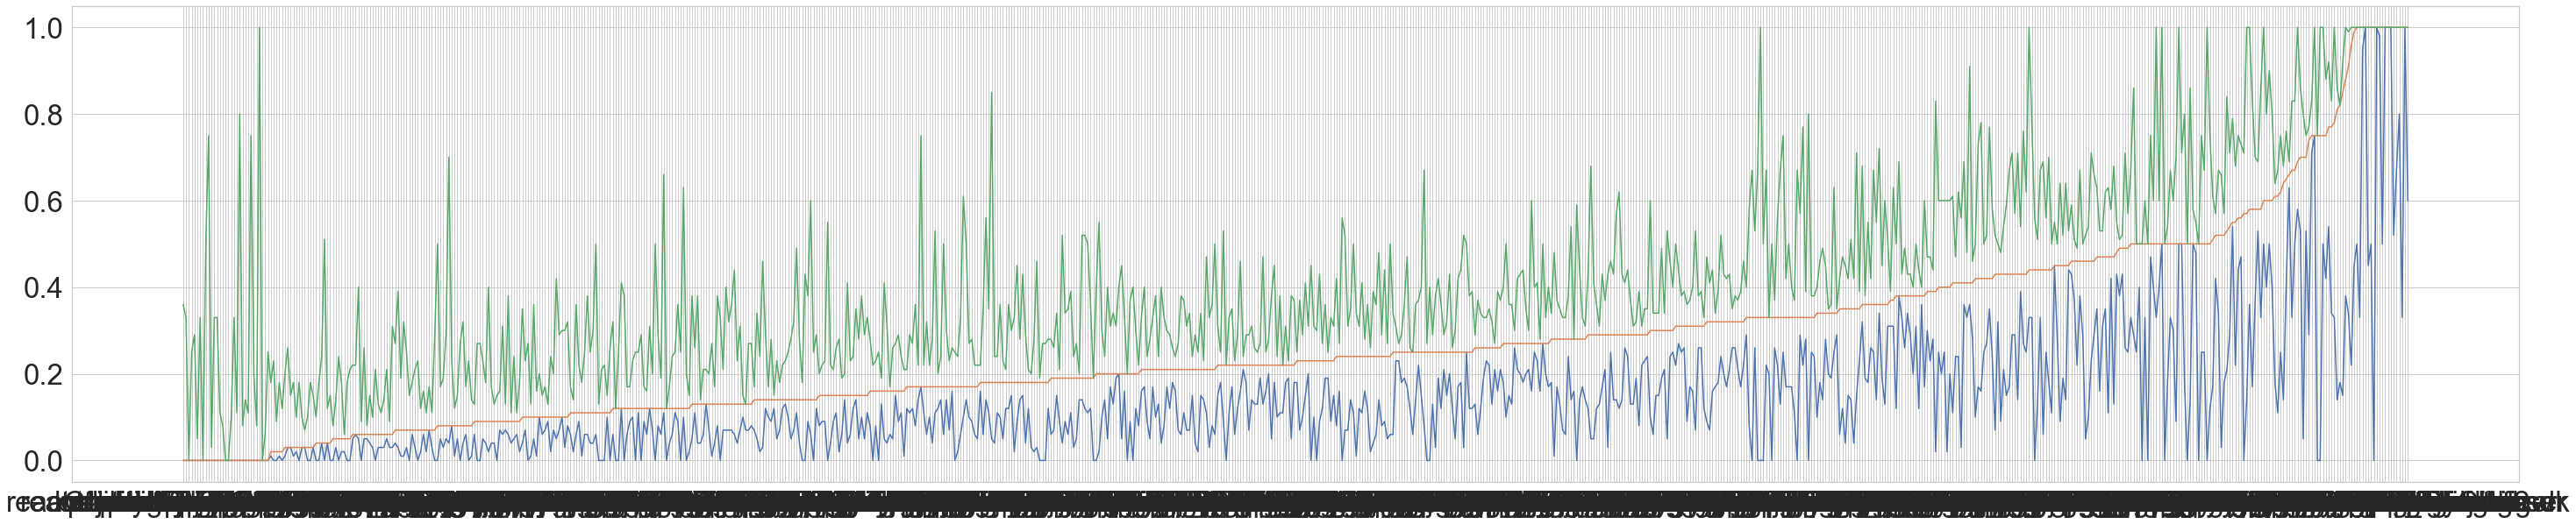

In [492]:
fig, ax = plt.subplots(figsize=(50,10))
ax.plot(lr_df)

In [533]:
cols = ['AvgCyclomatic', 'AvgCyclomaticModified', 'AvgCyclomaticStrict',
       'AvgEssential', 'AvgLine', 'AvgLineBlank', 'AvgLineCode',
       'AvgLineComment', 'CountClassBase', 'CountClassCoupled',
       'CountClassCoupledModified', 'CountClassDerived',
       'CountDeclClassMethod', 'CountDeclClassVariable',
       'CountDeclInstanceMethod', 'CountDeclInstanceVariable',
       'CountDeclMethod', 'CountDeclMethodAll', 'CountDeclMethodDefault',
       'CountDeclMethodPrivate', 'CountDeclMethodProtected',
       'CountDeclMethodPublic', 'CountLine', 'CountLineBlank', 'CountLineCode',
       'CountLineCodeDecl', 'CountLineCodeExe', 'CountLineComment',
       'CountSemicolon', 'CountStmt', 'CountStmtDecl', 'CountStmtExe',
       'MaxCyclomatic', 'MaxCyclomaticModified', 'MaxCyclomaticStrict',
       'MaxEssential', 'MaxInheritanceTree', 'MaxNesting',
       'PercentLackOfCohesion', 'PercentLackOfCohesionModified',
       'RatioCommentToCode', 'SumCyclomatic', 'SumCyclomaticModified',
       'SumCyclomaticStrict', 'SumEssential', 'la', 'ld', 'lt',
       'age', 'ddev', 'nuc', 'own', 'minor', 'ndev',
       'ncomm', 'adev', 'nadev', 'avg_nddev',
       'avg_nadev', 'avg_ncomm', 'ns', 'exp', 'sexp','rexp', 'nd', 'sctr']

In [534]:
df = pd.DataFrame()

for i in cols:
    df[i] = [0]*66

In [536]:
df = df.T

In [538]:
df.to_csv('results/data_stats.csv')

In [550]:
df = pd.read_pickle('results/Performance/commit_guru_file_specific/process_700_rf_5_fold_5_repeat.pkl')
df = df['featue_importance']
df = pd.DataFrame.from_dict(df,orient='index')
df.columns = ['la', 'ld', 'lt', 'age', 'ddev',
       'nuc', 'own', 'minor', 'ndev', 'ncomm', 'adev',
       'nadev', 'avg_nddev', 'avg_nadev', 'avg_ncomm',
       'ns', 'exp', 'sexp', 'rexp', 'nd', 'sctr']
df_stats = pd.DataFrame(df.quantile([.25, .5, .75]))
df_stats = df_stats.T
df_stats.columns = ['25th','50th','75th']
df_stats_rf = df_stats.sort_values(by = ['50th'])
df_stats_rf['rank_rf'] = range(0,21)
df_stats_rf = df_stats_rf.drop(['25th','50th','75th'],axis = 1)
# df_stats_rf = df_stats_lr.reset_index()
df = pd.read_pickle('results/Performance/commit_guru_file_specific/process_700_lr_5_fold_5_repeat_feature.pkl')
df = df['featue_importance']
for key in df.keys():
    df[key] = df[key][0]
df = pd.DataFrame.from_dict(df,orient='index')
df.columns = ['la', 'ld', 'lt', 'age', 'ddev',
       'nuc', 'own', 'minor', 'ndev', 'ncomm', 'adev',
       'nadev', 'avg_nddev', 'avg_nadev', 'avg_ncomm',
       'ns', 'exp', 'sexp', 'rexp', 'nd', 'sctr']
df_stats = pd.DataFrame(df.quantile([.25, .5, .75]))
df_stats = df_stats.T
df_stats.columns = ['25th','50th','75th']

In [551]:
df_stats

,25th,50th,75th
la,0.245142,1.317171,2.599242
ld,-0.501845,0.109868,0.624796
lt,0.203743,1.031171,2.008677
age,-1.378841,-0.241165,0.417771
ddev,-2.087987,-0.575307,0.241794
nuc,-0.794726,-0.208220,0.325906
own,-0.537934,0.000000,0.618199
minor,-1.039710,-0.204112,0.330348
ndev,-0.635871,0.163593,0.807090
ncomm,-0.418276,0.125358,0.607992


In [556]:
abs(0.125783)

0.125783